# Daily-News-for-Stock-Market-Prediction
Dataset from https://www.kaggle.com/aaron7sun/stocknews

In [1]:
!unzip stocknews.zip

Archive:  stocknews.zip
  inflating: Combined_News_DJIA.csv  
  inflating: DJIA_table.csv          
  inflating: RedditNews.csv          


In [2]:
import pandas as pd
import re
import math
import copy
import time
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from random import sample

!pip install bpemb
from bpemb import BPEmb


     |████████████████████████████████| 1.0MB 14.3MB/s 


#Data Preprocessing

In [3]:
news_data = pd.read_csv("Combined_News_DJIA.csv")
news_data = news_data.fillna('')
news_data.isnull().sum(axis = 0)
news_headers = list(filter(lambda x: 'Top' in x, news_data.columns))
col = 'news'
news_data[col] = ""
for i in news_headers:
  news_data[col] += " " + news_data[i]
  

news_data[col] = [re.sub(r'\W', ' ', row) for row in news_data[col]]

news_data[col] = [re.sub(r'\n+', ' ', row) for row in news_data[col]]

news_data[col] = [re.sub(r'\t+', ' ', row) for row in news_data[col]]

news_data[col] = [re.sub(r'\s+[b]\s+', '', row) for row in news_data[col]]

news_data[col] = [re.sub(r'\s+', ' ', row, flags=re.I) for row in news_data[col]]

news_data[col] = [re.sub(r'^\s+', '', row, flags=re.I) for row in news_data[col]]

news_data[col] = [re.sub(r'^\n+', '', row, flags=re.I) for row in news_data[col]]

news_data[col] = [re.sub(r'^\t+', '', row, flags=re.I) for row in news_data[col]]

news_data[col] = [re.sub(r'^b\s+', '', row) for row in news_data[col]]

n_embedding_dims = 100
bpemb_en = BPEmb(lang="en", dim=n_embedding_dims)

downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.model


100%|██████████| 3784656/3784656 [00:00<00:00, 41168714.99B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.d100.w2v.bin.tar.gz


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
class RNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.LSTMCell(input_size, hidden_size).to(device)
        
    def forward(self, input, hidden, cell):
        hidden, cell = self.i2h(input, (hidden, cell))
        return hidden, cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size, device = device)
    def initCell(self):
        return torch.zeros(1, self.hidden_size, device = device)      
      
class Classifier(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.h2o = nn.Linear(hidden_size, output_size).to(device)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, hidden):
        hidden = self.h2o(hidden)
        output = self.softmax(hidden)
        return output

In [0]:
def random_row_to_tensor(data):
    row = news_data.sample(n=1)
    line = row['news'].values.tolist()[0]
    embedding = bpemb_en.embed(line)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = row['Label'].values.tolist()[0]
    label_tensor = torch.tensor([label], dtype=torch.long, device=device)
    claim_tensor = torch.tensor(embedding, dtype=torch.float, device=device)
    return claim_tensor, label_tensor, line, label

def row_to_tensor(row):
    line = row['news']
    embedding = bpemb_en.embed(line)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = row['Label']
    label_tensor = torch.tensor([label], dtype=torch.long, device=device)
    claim_tensor = torch.tensor(embedding, dtype=torch.float, device=device)
    return claim_tensor, label_tensor, line, label  
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
  

In [0]:
def train(category_tensor, line_tensor, update=True):
    rnnOptimizer.zero_grad()
    classifierOptimizer.zero_grad()

    hidden = rnn.initHidden()
    cell = rnn.initCell()
    for i in range(line_tensor.size()[0]):
        hidden, cell = rnn(line_tensor[i], hidden, cell)
    output = classifier(hidden)
    loss = criterion(output, category_tensor)
    if update:
      loss.backward()
      rnnOptimizer.step()
      classifierOptimizer.step()        
    return output, loss.item()
  
def test(test_data):   
  test_accuracy = 0
  for index, row in test_data.iterrows():      
      test_line_tensor, test_category_tensor, test_line, test_category = row_to_tensor(row)
      test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
      top_test_value, top_test_index = test_output.topk(1)
      test_guess_category = top_test_index[0].item()
      test_accuracy += 1 if test_guess_category == test_category else 0
  return test_accuracy / len(test_data)

In [7]:
train_data = news_data[news_data['Date'] < '2015-01-01']
test_data = news_data[news_data['Date'] > '2014-12-31']
print(f'train data size = {len(train_data)}')
print(f'test data size = {len(test_data)}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_hidden = 128
n_categories = 2
rnn = RNNLSTM(n_embedding_dims, n_hidden).to(device)
classifier = Classifier(n_hidden, n_categories).to(device)

criterion = nn.NLLLoss()
learning_rate = 1e-4
rnnOptimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

n_iters = 60000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

train_cumulative_loss = 0
average_train_accuracy = 0
all_train_losses = []
all_train_accuracies = []
all_test_accuracies = []

count = 0
for iter in range(1, n_iters + 1):  
    train_line_tensor, train_category_tensor, train_line, train_category = random_row_to_tensor(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)

    count += 1

    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_line, train_guess_category, train_correct))
        all_train_losses.append(train_cumulative_loss / plot_every)
        all_train_accuracies.append(average_train_accuracy) 
        all_test_accuracies.append(test(test_data))
        train_cumulative_loss = 0
        average_train_accuracy = 0              
        count = 0        


train data size = 1611
test data size = 378
Train: 1000  1% (1m 54s) average_accuracy=0.5430 average_loss=0.6877 Azerbaijan accidentally released election results before voting had even started It showed President Ilham Aliyev winning 73 to the opposition s 7 China warns US to stop manufacturing crises and raise debt ceiling China criticises mind boggling political infighting over issue of raising America s 16 7 trillion debt ceiling A farmer commits suicide every two days in France almost 500 in three years Armed rebels kidnap Libya s prime minister William Binney is a man on a mission He spent nearly 30 years as a top executive in America s super secret National Security Agency NSA now he wants you to know that same spy agency is pushing western democracies including Canada toward fascism Girl slain after alerting police about stalker Indigenous Woman Gives Birth On Hospital Lawn In Mexico After Doctors Denied Her Care Four U S whistleblowers who have met with former National Securit

Overall test accuracy = 0.9920634920634921


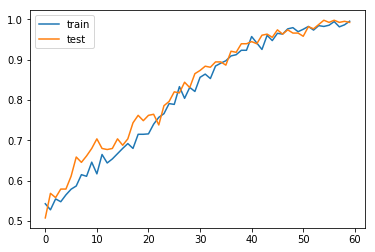

In [10]:
plt.figure()
plt.plot(all_train_accuracies, label='train')
plt.plot(all_test_accuracies,label='test')
plt.legend()

print(f'Overall test accuracy = {test(test_data)}')
    